# Collaboration Continuous Control

Trained two agents to play simple table tennis. Used the Multi-Agent Deep Deterministic Policy Gradient (MLDDPG), a shared memory (replay buffer), separate actors, and one shared critic.

### 1. Start Environment

In [1]:
# install dependencies, comment out after run once
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


Please visit https://github.com/Unity-Technologies/ml-agents to download the simulator.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")
# env = UnityEnvironment(file_name="tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# display baisc environment info
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 5. MADDPG Training

In [5]:
# import agents, replay buffer, OU noise
from actor import Actor
from critic import Critic
from collections import deque
from replay_buffer import ReplayBuffer
from noise import OUNoise
import torch

# train on GPU cuda if available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# hyperparameters (order by importance)
LR_ACTOR = 1e-4         # learning rate (actor)
LR_CRITIC = 3e-4        # learning rate (critic)
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.95            # discount factor
TAU = 0.2               # portion of local merged into target
ADD_NOISE = True
BUFFER_SIZE = int(1e6)  # replay buffer size
SEED = 1

# memory and noise are shared between the agents for efficiency
shared_memory = ReplayBuffer(DEVICE, action_size, BUFFER_SIZE, BATCH_SIZE, SEED)
noise = OUNoise(action_size, SEED)

# designed critics is be shared but not the actor
actor_1 = Actor(DEVICE, state_size, action_size, SEED, shared_memory, noise, LR_ACTOR)
actor_2 = Actor(DEVICE, state_size, action_size, SEED, shared_memory, noise, LR_ACTOR)
critic = Critic(DEVICE, state_size, action_size, SEED, GAMMA, TAU, LR_CRITIC)

In [7]:
def maddpg_train():
    # make sure to set n_episodes as a big number
    scores = []
    scores_deque = deque(maxlen=100)
    n_episodes = 1000

    for episode in range(n_episodes):
        # preparation
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        actor_1.reset()
        actor_2.reset()                        
        score = np.zeros(num_agents)
        
        while True:
            # get actions with actors
            action_1 = actor_1.act(states[0], ADD_NOISE)
            action_2 = actor_2.act(states[1], ADD_NOISE)
            actions = np.concatenate((action_1, action_2))
        
            # take action and retrieve new env info
            env_info = env.step(actions)[brain_name]                     
            next_states = env_info.vector_observations
            rewards = env_info.rewards      
            dones = env_info.local_done

            # step actors and critic to perform backpropagation
            actor_1.step(states[0], action_1, rewards[0], next_states[0], dones[0])
            actor_2.step(states[1], action_2, rewards[1], next_states[1], dones[1])
            critic.step(actor_1, shared_memory)
            critic.step(actor_2, shared_memory)

            # new score and new state
            score += rewards
            states = next_states        
                     
            # break out if done
            if np.any(dones):      
                break                                        

        # manage score for display and measure progress
        scores.append(np.max(score))
        scores_deque.append(np.max(score))
        
        # monitor progress
        print('\rEpisode {}\tScore: \t{:.2f}\tAverage Score: {:.2f}'.format(episode, np.max(score), np.mean(scores_deque)))  
        
        # save progress
        torch.save(actor_1.local.state_dict(), 'checkpoint_actor1.pth')
        torch.save(actor_2.local.state_dict(), 'checkpoint_actor2.pth')
        torch.save(critic.local.state_dict(), 'checkpoint_critic.pth')
        
        # finish function if benchmark reached
        if np.mean(scores_deque) >= 0.5:
            print('Solved in {} episodes. Woohoo'.format(episode-100))
            break
        
    return scores

In [8]:
scores = maddpg_train()

Episode 0	Score: 	0.09	Average Score: 0.09
Episode 1	Score: 	0.00	Average Score: 0.05
Episode 2	Score: 	0.00	Average Score: 0.03
Episode 3	Score: 	0.00	Average Score: 0.02
Episode 4	Score: 	0.00	Average Score: 0.02
Episode 5	Score: 	0.00	Average Score: 0.02
Episode 6	Score: 	0.00	Average Score: 0.01
Episode 7	Score: 	0.10	Average Score: 0.02
Episode 8	Score: 	0.00	Average Score: 0.02
Episode 9	Score: 	0.00	Average Score: 0.02
Episode 10	Score: 	0.00	Average Score: 0.02
Episode 11	Score: 	0.00	Average Score: 0.02
Episode 12	Score: 	0.00	Average Score: 0.01
Episode 13	Score: 	0.00	Average Score: 0.01
Episode 14	Score: 	0.00	Average Score: 0.01
Episode 15	Score: 	0.00	Average Score: 0.01
Episode 16	Score: 	0.00	Average Score: 0.01
Episode 17	Score: 	0.00	Average Score: 0.01
Episode 18	Score: 	0.00	Average Score: 0.01
Episode 19	Score: 	0.00	Average Score: 0.01
Episode 20	Score: 	0.00	Average Score: 0.01
Episode 21	Score: 	0.00	Average Score: 0.01
Episode 22	Score: 	0.00	Average Score: 0.0

Episode 185	Score: 	0.30	Average Score: 0.09
Episode 186	Score: 	0.30	Average Score: 0.10
Episode 187	Score: 	0.00	Average Score: 0.10
Episode 188	Score: 	0.10	Average Score: 0.10
Episode 189	Score: 	0.60	Average Score: 0.10
Episode 190	Score: 	0.09	Average Score: 0.10
Episode 191	Score: 	0.10	Average Score: 0.10
Episode 192	Score: 	0.20	Average Score: 0.11
Episode 193	Score: 	0.10	Average Score: 0.11
Episode 194	Score: 	0.10	Average Score: 0.11
Episode 195	Score: 	0.70	Average Score: 0.11
Episode 196	Score: 	0.20	Average Score: 0.12
Episode 197	Score: 	0.00	Average Score: 0.11
Episode 198	Score: 	0.30	Average Score: 0.12
Episode 199	Score: 	0.60	Average Score: 0.12
Episode 200	Score: 	0.99	Average Score: 0.13
Episode 201	Score: 	0.60	Average Score: 0.14
Episode 202	Score: 	1.30	Average Score: 0.15
Episode 203	Score: 	0.10	Average Score: 0.15
Episode 204	Score: 	0.30	Average Score: 0.15
Episode 205	Score: 	0.10	Average Score: 0.15
Episode 206	Score: 	0.00	Average Score: 0.15
Episode 20

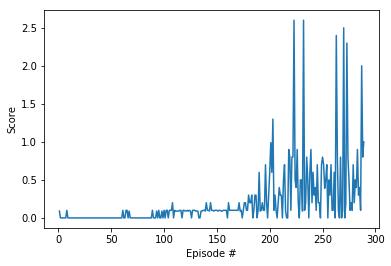

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot progress
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
# test agent
for episode in range(3):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    score = np.zeros(num_agents)
    
    while True:
        # very similar to the MADDPG function
        action_0 = actor_1.act(states[0], add_noise=False)
        action_1 = actor_2.act(states[1], add_noise=False)
        actions = np.concatenate((action_0, action_1))
        
        env_info = env.step( actions )[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done     
        
        score += rewards
        states = next_states
        if np.any(dones):                              
            break

    print('Episode: {}\tScore: {:.2f}'.format(episode, np.max(score)))  

Episode: 0	Score: 2.60
Episode: 1	Score: 2.70
Episode: 2	Score: 2.60
